In [1]:
!pip install ultralytics

In [2]:
!pip install pyttsx3
!apt install espeak

'apt' is not recognized as an internal or external command,
operable program or batch file.


In [71]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import ultralytics
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sns
from skimage.metrics import structural_similarity
from ultralytics import YOLO
import threading
import pyttsx3
import time
import math
import datetime
import pytz

In [72]:
ist = pytz.timezone('Asia/Kolkata')

# Adaptive Thresholding

In [58]:
cap = cv2.VideoCapture('vehicle_fire.mp4')

# print(cap)

# print(time.asctime(time.localtime(time.time())))

arr = np.empty((0, 256), int)

start_time = time.time()
while cap.isOpened():

    ret, frame = cap.read()

    if ret == True:
        frame_grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist(frame, [0], None, [256], [0, 256])
        hist1= hist.flatten()
        #print(hist1.shape)
        arr =np.vstack((arr, list(hist1)))
    else:
        break

print("--- %s seconds ---" % (time.time() - start_time))

# print(start_time)
# print(time.time())

print(arr.shape)

--- 12.124680042266846 seconds ---
(1168, 256)


In [5]:
#similarity threshold
stat = [arr.mean(), arr.std()]
print(stat)
stat = np.array(stat)
normalized_stat = stat / np.linalg.norm(stat)
adaptive_threshold = normalized_stat[1]*1 + normalized_stat[0]*0.1
adaptive_threshold

[15.0, 31.78411732681018]


0.9470286304540282

In [60]:
#dense cluster threshold
cluster_threshold = math.floor(stat[0]) + math.floor(stat[1])
cluster_threshold

46

# Key Frame Extraction

In [7]:
cap = cv2.VideoCapture('vehicle_fire.mp4')

arr = np.empty((0, 1944), int)   #1944 dimensional array for feature vector
D=dict()
count=0
start_time = time.time()
while cap.isOpened():

    # Read the video file.
    ret, frame = cap.read()

    if ret == True:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        D[count] = frame_rgb

        #3*3 = 9 blocks
        height, width, channels = frame_rgb.shape

        if height % 3 == 0:
            h_chunk = int(height/3)
        else:
            h_chunk = int(height/3) + 1

        if width % 3 == 0:
            w_chunk = int(width/3)
        else:
            w_chunk = int(width/3) + 1

        h=0
        w= 0
        feature_vector = []
        for a in range(1,4):
            h_window = h_chunk*a
            for b in range(1,4):
                frame = frame_rgb[h : h_window, w : w_chunk*b , :]
                hist = cv2.calcHist(frame, [0, 1, 2], None, [6, 6, 6], [0, 256, 0, 256, 0, 256])
                hist1= hist.flatten()
                feature_vector += list(hist1)
                w = w_chunk*b

            h = h_chunk*a
            w= 0


        arr =np.vstack((arr, feature_vector )) #N*M matrix (N is number of frames and M is 1944)
        count+=1
    else:
        break

print("--- %s seconds ---" % (time.time() - start_time))

final_arr = arr.transpose() # M*N

print(final_arr.shape)
print(count)

--- 27.348201274871826 seconds ---
(1944, 1168)
1168


In [8]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs
A = csc_matrix(final_arr, dtype=float) #sparse matrix

In [9]:
#type(final_arr)

In [10]:
col = []
for i in range(0,count):
    col.append(i)

col[0:1]

[0]

In [11]:
import pandas as pd

df1 = pd.DataFrame(final_arr, columns=col)
df1

,0,1,2,3,4,5,6,7,8,9,...,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167
0,404.0,404.0,404.0,404.0,404.0,410.0,410.0,410.0,409.0,410.0,...,321.0,422.0,396.0,389.0,388.0,355.0,334.0,326.0,335.0,357.0
1,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,...,0.0,0.0,1.0,1.0,0.0,5.0,10.0,10.0,6.0,7.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
steps = [('scaler', StandardScaler()), ('pca', PCA())]
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps) # define the pipeline object.

In [13]:
parameters = {
    "pca__n_components": [10, 20, 30, 40, 50, 60],
}

In [14]:
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

In [15]:
grid.fit(df1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA())]),
             param_grid={'pca__n_components': [10, 20, 30, 40, 50, 60]})

In [16]:
print("score = %3.2f" %(grid.score(df1)))
print(grid.best_params_)

score = 15.76
{'pca__n_components': 10}


In [17]:
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(df1))
scaled_data

,0,1,2,3,4,5,6,7,8,9,...,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167
0,6.217441,6.217441,6.217608,6.212193,6.210343,6.300269,6.300076,6.300076,6.283361,6.296956,...,5.982742,8.006183,7.553924,7.184208,7.215387,6.657701,6.277097,6.317546,6.276522,6.858828
1,0.141726,0.141726,0.141730,0.141607,0.141564,0.141482,0.141477,0.141477,0.141452,0.141407,...,-0.112524,-0.114028,-0.095392,-0.092381,-0.111910,-0.017660,0.077950,0.080413,0.001413,0.020984
2,-0.092556,-0.092556,-0.092558,-0.092478,-0.092450,-0.092396,-0.092393,-0.092393,-0.092377,-0.092348,...,-0.112524,-0.114028,-0.114758,-0.111135,-0.111910,-0.113022,-0.113382,-0.116965,-0.113027,-0.115773
3,-0.092556,-0.092556,-0.092558,-0.092478,-0.092450,-0.092396,-0.092393,-0.092393,-0.092377,-0.092348,...,-0.112524,-0.114028,-0.114758,-0.111135,-0.111910,-0.113022,-0.113382,-0.116965,-0.113027,-0.115773
4,-0.092556,-0.092556,-0.092558,-0.092478,-0.092450,-0.092396,-0.092393,-0.092393,-0.092377,-0.092348,...,-0.112524,-0.114028,-0.114758,-0.111135,-0.111910,-0.113022,-0.113382,-0.116965,-0.113027,-0.115773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,-0.092556,-0.092556,-0.092558,-0.092478,-0.092450,-0.092396,-0.092393,-0.092393,-0.092377,-0.092348,...,-0.112524,-0.114028,-0.114758,-0.111135,-0.111910,-0.113022,-0.113382,-0.116965,-0.113027,-0.115773
1940,-0.092556,-0.092556,-0.092558,-0.092478,-0.092450,-0.092396,-0.092393,-0.092393,-0.092377,-0.092348,...,-0.112524,-0.114028,-0.114758,-0.111135,-0.111910,-0.113022,-0.113382,-0.116965,-0.113027,-0.115773
1941,-0.092556,-0.092556,-0.092558,-0.092478,-0.092450,-0.092396,-0.092393,-0.092393,-0.092377,-0.092348,...,-0.112524,-0.114028,-0.114758,-0.111135,-0.111910,-0.113022,-0.113382,-0.116965,-0.113027,-0.115773
1942,-0.092556,-0.092556,-0.092558,-0.092478,-0.092450,-0.092396,-0.092393,-0.092393,-0.092377,-0.092348,...,-0.112524,-0.114028,-0.114758,-0.111135,-0.111910,-0.113022,-0.113382,-0.116965,-0.113027,-0.115773


In [18]:
pca_c =  grid.best_params_['pca__n_components']
pca_c

10

In [19]:
colnames = []
for i in range(1, pca_c+1):
    col_name = "v" + str(i)
    colnames+= [col_name]
print(colnames)

['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10']


In [20]:
scaled_data1 = scaled_data.transpose()

In [21]:
pca = PCA(n_components = pca_c)
pca.fit(scaled_data1)
data_pca = pca.transform(scaled_data1)
data_pca = pd.DataFrame(data_pca,columns=colnames)
data_pca.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10
0,25.638930,-7.864912,-5.218398,5.433125,2.433957,-0.278110,0.340907,-0.072023,3.793079,0.633835
1,25.638930,-7.864912,-5.218398,5.433125,2.433957,-0.278110,0.340907,-0.072023,3.793079,0.633835
2,25.606073,-7.958917,-5.216836,5.485765,2.370862,-0.267179,0.250988,-0.032633,3.746282,0.630704
3,25.592047,-7.968053,-5.217785,5.483234,2.316151,-0.234787,0.259220,-0.063988,3.723081,0.668763
4,25.619524,-7.964722,-5.200423,5.430062,2.277675,-0.235508,0.261385,-0.093529,3.762434,0.626065


In [22]:
#data_pca.shape

In [23]:
df2 = data_pca.transpose()

In [24]:
#df2.shape

In [25]:
projections = data_pca.to_numpy()

In [26]:
f=projections
C = dict() #clusters
for i in range(f.shape[0]):
    C[i] = np.empty((0,pca_c), int)

#first two projected frames in first cluster
C[0] = np.vstack((C[0], f[0]))
C[0] = np.vstack((C[0], f[1]))

E = dict() #centroids
for i in range(projections.shape[0]):
    E[i] = np.empty((0,pca_c), int)

E[0] = np.mean(C[0], axis=0) #finding centroid of C[0] cluster

count = 0
for i in range(2,f.shape[0]):
    #print(i)
    #similarity = np.dot(f[i], E[count])/( (np.dot(f[i],f[i]) **.5) * (np.dot(E[count], E[count]) ** .5)) #cosine similarity
    similarity = structural_similarity(f[i], E[count], data_range=255)
    print(similarity)


    if similarity < adaptive_threshold:

        count+=1
        C[count] = np.vstack((C[count], f[i]))
        E[count] = np.mean(C[count], axis=0)
    else:
        C[count] = np.vstack((C[count], f[i]))
        E[count] = np.mean(C[count], axis=0)

0.9999353471017344
0.9999339187072753
0.9999089578637741
0.9999490047835364
0.9998828673830042
0.999913898937264
0.9998443412930835
0.9998510252448364
0.9998795418303793
0.9998455582345926
0.9998576512137332
0.9998278696636465
0.9997760051486058
0.9996387580786441
0.9985691766097038
0.9970845915476813
0.9963706407159542
0.9966320844131481
0.9966432470678213
0.9965373320660134
0.991031421517252
0.9877933438756177
0.9941486600797288
0.9943541812827665
0.9912430217901218
0.9828676619695158
0.9781082706003243
0.9769129689521251
0.9720786249086673
0.9732385190926462
0.9708631180046376
0.9669617830974794
0.9704010441241018
0.9676566610558351
0.9679793262425118
0.969283327757828
0.967408088789699
0.9619993523212901
0.9511228158219843
0.9538670331321906
0.9509008564964274
0.953043401422868
0.9576393885144242
0.9532120745321097
0.9333498174944886
0.9981087475276349
0.9979250286330281
0.9990012301517186
0.998827718577314
0.997483270636496
0.997025145475885
0.9960401763898555
0.9936121345111204
0

0.9761809441293505
0.9808491825676117
0.990229822220639
0.9934750752025067
0.9930931485305445
0.9757446939901805
0.992806478687098
0.9790369309756816
0.9526738000941488
0.9479274726838179
0.9544511744602069
0.9615115525317645
0.964673658266113
0.9696372345058517
0.9708380473767081
0.9673823264520013
0.9426846961451358
0.9791080254031116
0.9677755584613451
0.9685040995788938
0.9889460818861859
0.987611687840924
0.9653421730113732
0.9835577679171015
0.9377928822407414
0.9984205230352698
0.9977650110429446
0.9940790075184226
0.8897307039892246
0.9244771026490584
0.9814651726446085
0.9754613151536491
0.9953548285868901
0.978460461553793
0.9553709276693847
0.8531922869505056
0.9558137988516345
0.8673317758944931
0.9934664403422179
0.996838094567458
0.967333114480224
0.9736770622861382
0.9922287520073529
0.9444623721558196
0.9669222864392241
0.9813318188283084
0.9755779662542249
0.9329191110442789
0.9905027612498727
0.690116526171336
0.9812856384092514
0.9627308422402983
0.9194996008497227
0

In [27]:
b = []  #number of data points in each cluster

for i in range(f.shape[0]):
    b.append(C[i].shape[0])

In [28]:
#C[0].shape

In [29]:
#b

In [30]:
last = b.index(0)
b1=b[:last ]
len(b1)

178

In [31]:
count = 1
while True:
    res = [idx for idx, val in enumerate(b1) if val >= (cluster_threshold/count)]
    #print("Res",len(res))
    #print("Count",count)
    if len(res)>=10:
        print("CLUSTER ThRESHOLD=",math.floor(cluster_threshold/count))
        break
    count+=1

print(len(res))
res

CLUSTER ThRESHOLD= 23
10


[0, 1, 3, 14, 16, 17, 19, 22, 31, 138]

In [32]:
GG = C #label each cluster
for i in range(last):
    p1= np.repeat(i, b1[i]).reshape(b1[i],1)
    GG[i] = np.hstack((GG[i],p1))

In [33]:
F=  np.empty((0,pca_c+1), int)
for i in range(last):
    F = np.vstack((F,GG[i]))

In [34]:
F.shape

(1168, 11)

In [35]:
colnames = []
for i in range(1, pca_c+2):
    col_name = "v" + str(i)
    colnames+= [col_name]
print(colnames)

df = pd.DataFrame(F, columns= colnames)

['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11']


In [36]:
last_col = df.columns[-1]

In [37]:
df[last_col]= df[last_col].astype(int)

In [38]:
df1 =  df[df[last_col].isin(res)]

In [39]:
new = df1.groupby(last_col).tail(1)[last_col] #last element of each cluster

In [40]:
new1 = new.index
new1

Index([45, 83, 107, 263, 292, 323, 373, 419, 470, 985], dtype='int64')

In [41]:
len(new1)

10

In [94]:
keyframe_dict = dict()
for i in new1:
    keyframe_dict[i] = D[i]
    
# print(keyframe_dict)

In [92]:
keyframe_arr = list(keyframe_dict.values())

In [44]:
keyframe_arr[0].shape

(720, 1280, 3)

(720, 1280, 3)
19 July 2023 Wednesday 22:46:06:621921
(720, 1280, 3)
19 July 2023 Wednesday 22:46:06:632717
(720, 1280, 3)
19 July 2023 Wednesday 22:46:06:642438
(720, 1280, 3)
19 July 2023 Wednesday 22:46:06:652539
(720, 1280, 3)
19 July 2023 Wednesday 22:46:06:664084
(720, 1280, 3)
19 July 2023 Wednesday 22:46:06:673664
(720, 1280, 3)
19 July 2023 Wednesday 22:46:06:683925
(720, 1280, 3)
19 July 2023 Wednesday 22:46:06:692916
(720, 1280, 3)
19 July 2023 Wednesday 22:46:06:702807
(720, 1280, 3)
19 July 2023 Wednesday 22:46:06:712388


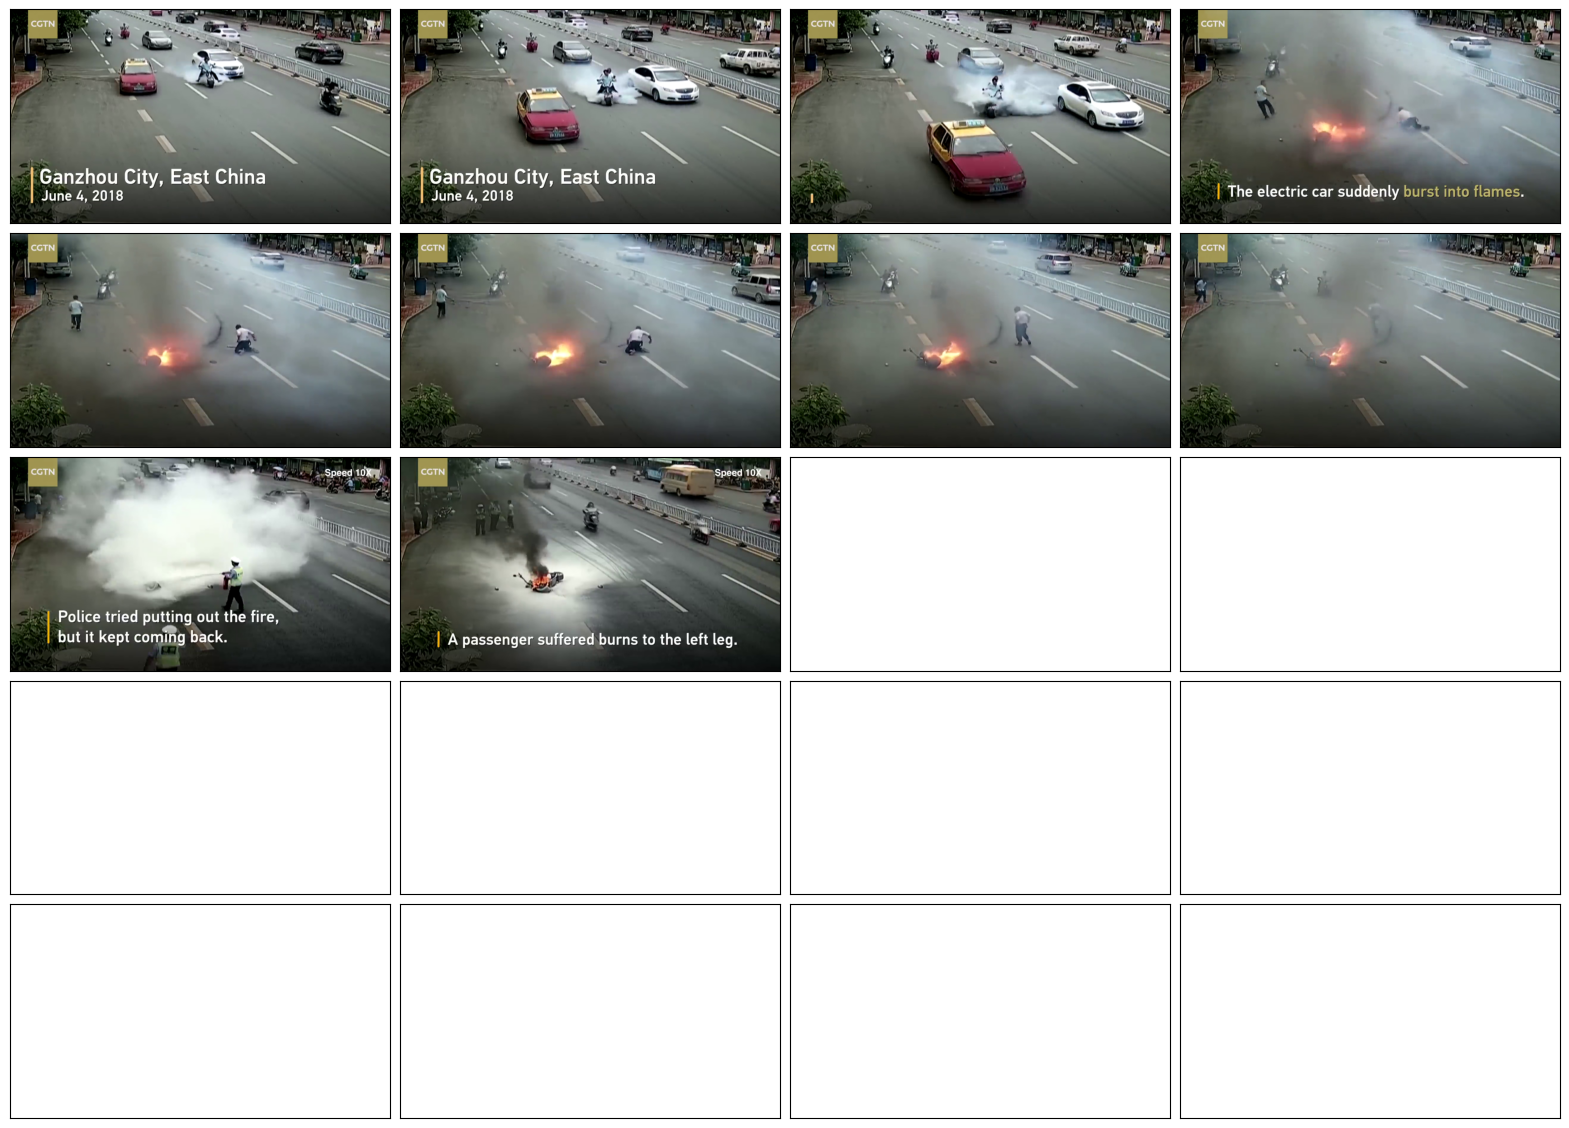

In [96]:
# similarity ?
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5,4),
                 axes_pad=0.1,
                 share_all=True
                 )
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])

for ax, im in zip(grid, keyframe_arr):    
   
#    start_time = time.asctime(time.istime())
    ist_now = datetime.datetime.now(tz=ist)
    start_time = ist_now.strftime('%d %B %Y %A %H:%M:%S:%f')
    print(im.shape)
    print(start_time)
    ax.imshow(im)

In [78]:
frameSize = (keyframe_arr[0].shape[1], keyframe_arr[0].shape[0])
output = cv2.VideoWriter('output/output_vehicle_fire.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 40, frameSize)
for frame in keyframe_arr:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    output.write(frame_rgb)
output.release()

# YOLO Detection

In [47]:
def thread_voice_alert_handgun(engine):
    engine.say("Handgun Detected")
    engine.runAndWait()

def thread_voice_alert_shotgun(engine):
    engine.say("Shotgun Detected")
    engine.runAndWait()

def thread_voice_alert_knife(engine):
    engine.say("Knife Detected")
    engine.runAndWait()

def thread_voice_alert_fire(engine):
    engine.say("Fire Detected")
    engine.runAndWait()

In [48]:
engine = pyttsx3.init()
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[1].id)
engine.setProperty('rate', 150)

In [62]:
model = YOLO("yolov8-50b-320i/weights/best.pt")

In [50]:
video_path = "output/output_vehicle_fire.mp4"
cap = cv2.VideoCapture(video_path)
no_frames = 0
start_time = time.time()
while cap.isOpened():
    success, frame = cap.read()

    if success:
        results = model(frame)
        #print(results[0].boxes.cls)
        no_frames+=1
        try:
            if (results[0].boxes.conf[0] > 0.50):
                c = results[0].boxes.cls[0]
                try:
                    if (c == 2):
                        t = threading.Thread(target=thread_voice_alert_handgun, args=(engine,))
                        t.start()
                    elif (c == 3):
                        t = threading.Thread(target=thread_voice_alert_shotgun, args=(engine,))
                        t.start()
                    elif(c == 1):
                        t = threading.Thread(target=thread_voice_alert_knife, args=(engine,))
                        t.start()
                    elif(c == 0):
                        t = threading.Thread(target=thread_voice_alert_fire, args=(engine,))
                        t.start()
                except:
                    pass

                annotated_frame = results[0].plot()
                cv2.imshow("YOLOv8 Inference", annotated_frame)

            else:
                cv2.imshow("YOLOv8 Inference", frame)
        except:
            pass

        if cv2.waitKey(1001) & 0xFF == ord("q"):
            break
    else:
        break

cap.release()
# cv2.destroyAllWindows()
end_time = time.time()
optimised_time=end_time - start_time - no_frames
print("#####PROCESSING TIME##### =", optimised_time, "seconds")

#####PROCESSING TIME##### = 0.0011217594146728516 seconds


# Testing

In [51]:
video_path = "vehicle_fire.mp4"
cap = cv2.VideoCapture(video_path)
start_time = time.time()
while cap.isOpened():
    success, frame = cap.read()

    if success:
        results = model(frame)
        #print(results[0].boxes.cls)
        try:
            if (results[0].boxes.conf[0] > 0.50):
                c = results[0].boxes.cls[0]
                try:
                    if (c == 2):
                        t = threading.Thread(target=thread_voice_alert_handgun, args=(engine,))
                        t.start()
                    elif (c == 3):
                        t = threading.Thread(target=thread_voice_alert_shotgun, args=(engine,))
                        t.start()
                    elif(c == 1):
                        t = threading.Thread(target=thread_voice_alert_knife, args=(engine,))
                        t.start()
                    elif(c == 0):
                        t = threading.Thread(target=thread_voice_alert_fire, args=(engine,))
                        t.start()
                except:
                    pass

                annotated_frame = results[0].plot()
                cv2.imshow("YOLOv8 Inference", annotated_frame)

            else:
                cv2.imshow("YOLOv8 Inference", frame)
        except:
            pass

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        break

cap.release()
# cv2.destroyAllWindows()
end_time = time.time()
original_time = end_time - start_time
print("#####PROCESSING TIME##### =", original_time, "seconds")


0: 192x320 1 knife, 722.1ms
Speed: 19.3ms preprocess, 722.1ms inference, 47.0ms postprocess per image at shape (1, 3, 192, 320)


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1338: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'


In [ ]:
times = [original_time, optimised_time]
times_series = pd.Series(times)
per_change = times_series.pct_change()
per_change